<h2>Simulating Lensed Quasar Light Curves with Microlensing

In this notebook, we will use one microlesning map, and and simulate lensed quasar curves in multiple bands. 

In [1]:
from amoeba.Classes.accretion_disk import AccretionDisk
from amoeba.Classes.magnification_map import MagnificationMap
import amoeba.Util.util as util
import numpy as np
import numpy.random as random
from astropy.io import fits
import astropy.constants as ac
import astropy.units as au
from astropy.nddata import block_reduce
from scipy import signal
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import sys
import time as supertime

example_disk_path = "../SampleDisks/RayTrace.fits"
example_mag_map_path = "/Users/padmavenkatraman/Documents/StrongLensing/AM/mapA.fits"  # Insert a path to a magnification map (download seperate)

In [2]:
util

<module 'amoeba.Util.util' from '/Users/padmavenkatraman/Documents/StrongLensing/AM/amoeba_ver2/Amoeba/amoeba/src/amoeba/Util/util.py'>

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


### Microlensing map

In this section we look at the microlensing map, make a histogram of the values and look at the magnification of the images.

In [4]:
example_mag_map_path = "/Users/padmavenkatraman/Documents/StrongLensing/AM/mapA.fits"  # Insert a path to a magnification map (download seperate)

8192


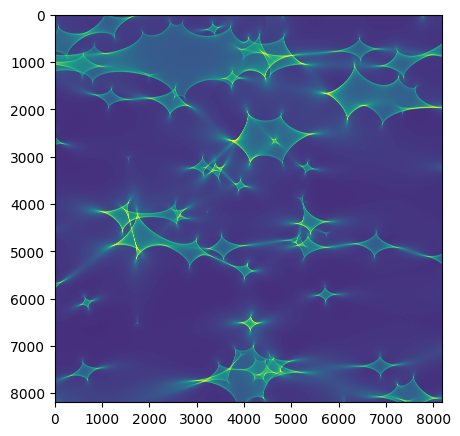

In [5]:
from astropy.visualization import simple_norm
fig, ax =plt.subplots(figsize=(5,6))
hdul = fits.open(example_mag_map_path)
hdul0 = hdul[0]
mag_map_num_pix = hdul0.shape[0]
star_mass = 0.3 # solar mass
zsrc = 1.29
zlens = 0.317
theta_e = 20 #number of einstein radii in map
norm = simple_norm(hdul0.data, stretch ='asinh', asinh_a=0.2, vmin=0, vmax=20)
ax.imshow(hdul0.data, cmap='viridis', norm=norm)
print(mag_map_num_pix)

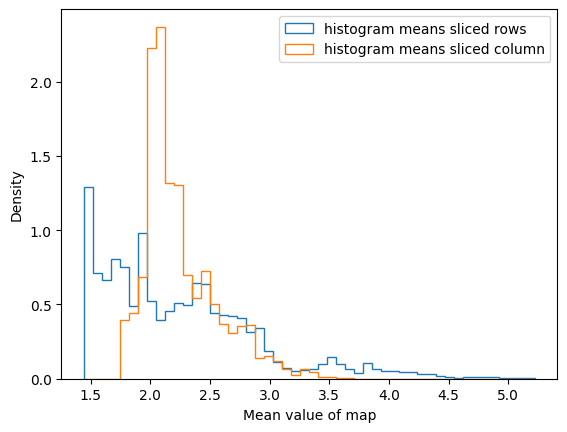

In [6]:
means_x = [np.mean(hdul0.data[i,:]) for i in range(8192)]
# fig, ax = plt.subplots(1,2,figsize=(10,5))
means_y = [np.mean(hdul0.data[:,i]) for i in range(8192)]
# ax[0].imshow(hdul0.data, cmap='viridis', norm=norm)
# ax[1].plot(means_x, means_y)
_,bins,_=plt.hist(means_x, density=True,label='histogram means sliced rows', bins=50,histtype='step')
plt.hist(means_y, density=True,label='histogram means sliced column',bins=bins,histtype='step');
plt.legend();
plt.xlabel("Mean value of map")
plt.ylabel("Density");

In [ ]:
mass_exponent = 8.0
number_gravitational_radii = 100
inclination_angle = 15
# resolution = 1000
# mass_exp,
# redshift,
# number_grav_radii,
# inclination_angle,
# resolution,
# spin=0,
# eddington_ratio=0.1,
# temp_beta=0,
# corona_height=6,
# albedo=1,
# eta=0.1,
# generic_beta=False,
# disk_acc=None,
# height_array=None,
# albedo_array=None,
# OmM=0.3,
# H0=70,
# efficiency=0.1,
# visc_temp_prof="SS",
# name="",
agn_dictionary = util.create_maps(

)
my_disk = AccretionDisk(**agn_dictionary)